# End to End Project Steps

#### 1 : Define Problem

#### 2 : Performance Metric

Common for regression problems is Root Mean Squared Error (RMSE)
 - The name is somewhat self explanatory
 - Find the error of prediction by subtracting truth from model prediction
 - Square each error
 - Average the squared errors
 - Take the square root of the avg > Get RMSE

Mean Absolute Error (MAE)
 - Find the error
 - Average the absolute values of the errors

RMSE is Euclidean norm, MAE is Manhattan norm

In [94]:
import sklearn
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request
import numpy as np
def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter="data")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing_full = load_housing_data()

In [95]:
housing_full

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [96]:
def shuffle_and_split_data(data, test_ratio, rng):
    shuffled_indices = rng.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [97]:
rng = np.random.default_rng(seed=42)
train_set, test_set = shuffle_and_split_data(housing_full, 0.2, rng)
len(train_set)

16512

In [98]:
len(test_set)

4128

In [99]:
# Sklearn will do this for us
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing_full, test_size=0.2,
                                       random_state=42)

In [100]:
len(train_set)

16512

#### Stratified Sampling

In [101]:
# bin the data
housing_full["income_cat"] = pd.cut(housing_full["median_income"],
                                    bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                    labels=[1, 2, 3, 4, 5])

In [102]:
# This makes sure you get roughly same number of each income category in each dataset
strat_train_set, strat_test_set = train_test_split(
    housing_full, test_size=0.2, stratify=housing_full["income_cat"],
    random_state=42)

In [103]:
strat_train_set["income_cat"].value_counts() / len(strat_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [104]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)
#Pretty good!

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [105]:
strat_test_set.drop(columns="income_cat", inplace=True)
strat_train_set.drop(columns="income_cat", inplace=True)
#dropping cols after because we dont need them

<Axes: xlabel='longitude', ylabel='latitude'>

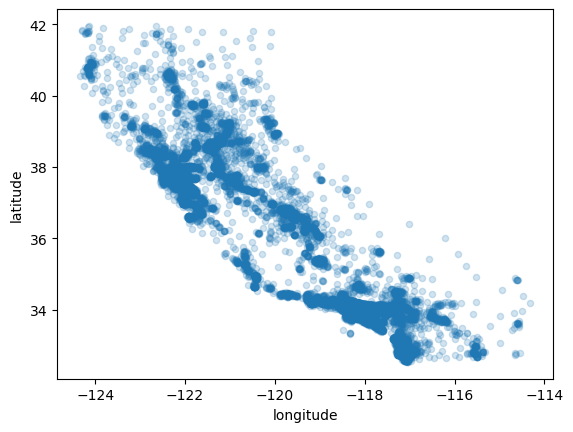

In [106]:
housing_full.plot(kind="scatter",x="longitude", y="latitude", alpha=0.2)

In [107]:
housing_full.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

<Axes: xlabel='median_income', ylabel='median_house_value'>

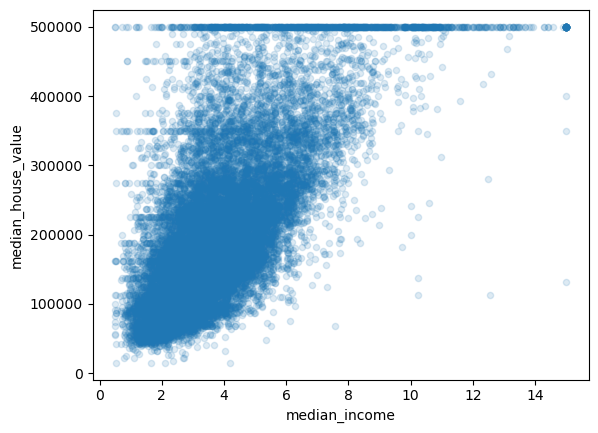

In [108]:
housing_full.plot(kind="scatter", x="median_income",y="median_house_value", alpha=0.15)
#Theres some horizontal lines that may be worth getting rid of to avoid the model learning these patterns

#### Adding Features 

In [109]:
housing = housing_full.copy()
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [110]:
housing.corr(numeric_only=True)["median_house_value"].sort_values(ascending=False)
#Bedroom ratio is decently negatively correlated, suggesting high value houses have less bedrooms per room

median_house_value    1.000000
median_income         0.688075
rooms_per_house       0.151948
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
people_per_house     -0.023737
population           -0.024650
longitude            -0.045967
latitude             -0.144160
bedrooms_ratio       -0.255880
Name: median_house_value, dtype: float64

In [111]:
# When creating new combined features, make sure they are not too linearly correlated with existing features: 
# collinearity can cause issues with some models, such as linear regression. 
# In particular, avoid simple weighted sums of existing features.

#### Data Preparation

In [112]:
trainingData = strat_test_set.drop(columns="median_house_value")
trainingLabels = strat_test_set["median_house_value"].copy()

In [113]:
trainingData.isna().sum()
# Options to fix missing: drop col, drop row, fill missing vals

longitude              0
latitude               0
housing_median_age     0
total_rooms            0
total_bedrooms        39
population             0
households             0
median_income          0
ocean_proximity        0
dtype: int64

In [114]:
# Dropping rows
missingIdxs = trainingData.loc[trainingData["total_bedrooms"].isna()].index
trainingData.dropna(subset=["total_bedrooms"], inplace=True)
trainingLabels = trainingLabels.loc[~trainingLabels.index.isin(missingIdxs)]

In [115]:
# Simple imputing with sklearn
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num)
X = imputer.transform(housing_num)

#### Other Imputers:
KNNImputer replaces each missing value with the mean of the k-nearest neighbors’ values for that feature. The distance is based on all the available features.

IterativeImputer trains a regression model per feature to predict the missing values based on all the other available features. It then trains the model again on the updated data, and repeats the process several times, improving the models and the replacement values at each iteration.

#### Scikit-learn API

*Estimators*

    Any object that can estimate some parameters based on a dataset (ie SimpleImputer)
    -estimation itself is performed by .fit()
    -fit takes one dataset as a parameter, and a second for supervised learning (the labels)
    -any other hyperparameters needed for estimation is set in the Estimator declaration
    
*Transformers*
    
    Some estimators that change datasets are also transformers (ie SimpleImputer)
    -transformation done with .transform()
    -All transformers have a method .fit_transform() which is equal to calling .fit then .transform (sometimes more efficient)

*Predictors*

    Some estimators than can make predictions based on data are Predictors (ie LinearRegression)
    -prediction is done with .predict()
    -predict() takes a dataset of new instances and responds with a dataset of predicted values
    -Also has .score() method which evaluates how good the predictions are given a test set
    


#### Handling Text and Categorical Variables

In [116]:
## Ordinal Encoding (cats to nums)
from sklearn.preprocessing import OrdinalEncoder
housing_cat = housing[["ocean_proximity"]]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded

array([[3.],
       [3.],
       [3.],
       ...,
       [1.],
       [1.],
       [1.]])

In [117]:
# One hot encoding in sklearn 
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
#get cats with cat_encoder.categories_
housing_cat_1hot.toarray()
#pandas way
#pd.get_dummies(housing_cat)

# Sklearn takes dataframes and is better than using pd methods because original cols are remembered

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#### Feature Scaling and Transformation

In [118]:
# ML models dont like data with different scales. If col A ranges from 0-100_000 and B ranges from 0-1, the model tends to bias to A

Important: Fit scalers to TRAINING DATA, and apply the scales to all other datasets (with .transform())

In [119]:
# Min Max-Scaling (Normalization)
# Change data to range from 0-1. 0 is min, 1 is max

from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(0, 1)) #feature range can be whatever you want
housing_num_min_max_scaled = min_max_scaler.fit_transform(housing_num)
pd.DataFrame(housing_num_min_max_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.211155,0.567481,0.784314,0.022331,0.019863,0.008941,0.020556,0.539668,0.902266,0.043512,0.051768,0.001499
1,0.212151,0.565356,0.392157,0.180503,0.171477,0.067210,0.186976,0.538027,0.708247,0.038224,0.061996,0.001141
2,0.210159,0.564293,1.000000,0.037260,0.029330,0.013818,0.028943,0.466028,0.695051,0.052756,0.032796,0.001698
3,0.209163,0.564293,1.000000,0.032352,0.036313,0.015555,0.035849,0.354699,0.672783,0.035241,0.093843,0.001493
4,0.209163,0.564293,1.000000,0.041330,0.043296,0.015752,0.042427,0.230776,0.674638,0.038534,0.080107,0.001198
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,0.324701,0.737513,0.470588,0.042296,0.057883,0.023599,0.054103,0.073130,0.130105,0.029769,0.138472,0.001503
20636,0.312749,0.738576,0.333333,0.017676,0.023122,0.009894,0.018582,0.141853,0.128043,0.037344,0.128009,0.001956
20637,0.311753,0.732200,0.313725,0.057277,0.075109,0.028140,0.071041,0.082764,0.159383,0.030904,0.127970,0.001314
20638,0.301793,0.732200,0.333333,0.047256,0.063315,0.020684,0.057227,0.094295,0.143713,0.031783,0.133214,0.001152


In [120]:
# Standardization
# Each val x is converted to (x-mean) / stdev

from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)
pd.DataFrame(housing_num_std_scaled)

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.327835,1.052548,0.982143,-0.804819,-0.970325,-0.974429,-0.977033,2.344766,2.129631,0.628559,-1.146024,-0.049597
1,-1.322844,1.043185,-0.607019,2.045890,1.348276,0.861439,1.669961,2.332238,1.314156,0.327041,-0.987254,-0.092512
2,-1.332827,1.038503,1.856182,-0.535746,-0.825561,-0.820777,-0.843637,1.782699,1.258693,1.155620,-1.440514,-0.025843
3,-1.337818,1.038503,1.856182,-0.624215,-0.718768,-0.766028,-0.733781,0.932968,1.165100,0.156966,-0.492925,-0.050329
4,-1.337818,1.038503,1.856182,-0.462404,-0.611974,-0.759847,-0.629157,-0.012881,1.172900,0.344711,-0.706141,-0.085616
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-0.758826,1.801647,-0.289187,-0.444985,-0.388895,-0.512592,-0.443449,-1.216128,-1.115804,-0.155023,0.199820,-0.049110
20636,-0.818722,1.806329,-0.845393,-0.888704,-0.920488,-0.944405,-1.008420,-0.691593,-1.124470,0.276881,0.037412,0.005021
20637,-0.823713,1.778237,-0.924851,-0.174995,-0.125472,-0.369537,-0.174042,-1.142593,-0.992746,-0.090318,0.036808,-0.071735
20638,-0.873626,1.778237,-0.845393,-0.355600,-0.305834,-0.604429,-0.393753,-1.054583,-1.058608,-0.040211,0.118204,-0.091225


In [121]:
# ML models dont like lots of very close values either, so try to get rid of skew / heavy tail
# transform data with log scales, square roots, whatever to try and make it look symmetric

In [122]:
# Bucketing : turn continuous nums into categories (ie percentile)
# bucketing is particularly good for multimodal distributions (multiple peaks)

Multimodal distributions can also be addressed by adding a feature for each peak that measures the distance from the peak

In [123]:
from sklearn.metrics.pairwise import rbf_kernel

age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]], gamma=0.1)
#gamma is a hyperparameter that defines how quickly x decays as it goes away from 35
age_simil_35

array([[2.73237224e-02],
       [3.07487988e-09],
       [2.81118530e-13],
       ...,
       [8.48904403e-15],
       [2.81118530e-13],
       [2.09879105e-16]])

In [124]:
# Most of scikit learns transformers have an inverse_transform() method that computes the inverse

Code that does StandardScaling, trains a linear regression model, then transform back to origin with inverse_transform()

In [125]:
from sklearn.linear_model import LinearRegression
housing_labels = housing["median_house_value"].copy()
target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(housing_labels.to_frame())

model = LinearRegression()
model.fit(housing[["median_income"]], scaled_labels)
some_new_data = housing[["median_income"]].iloc[:5] 

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)
predictions

array([[393027.73007889],
       [392033.03646789],
       [348400.25790111],
       [280932.44713449],
       [205833.0795036 ]])

In [126]:
# Transformed Target Regressor will avoid any potential scaling mismatches
# need to give it regession model, label transformer, and fit it on training set
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(),
                                   transformer=StandardScaler())
model.fit(housing[["median_income"]], housing_labels)
predictions = model.predict(some_new_data)
predictions

array([393027.73007889, 392033.03646789, 348400.25790111, 280932.44713449,
       205833.0795036 ])

#### Making our own Transformer

In [127]:
from sklearn.preprocessing import FunctionTransformer

log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
log_pop = log_transformer.transform(housing[["population"]])
#inverse_func is optional, but lets you use it in TransformedTargetRegressor

In [128]:
# What if you wanted a feature that measured distance from San Francisco
sf_coords = 37.7749, -122.41
sf_transformer = FunctionTransformer(rbf_kernel,
                                     kw_args=dict(Y=[sf_coords], gamma=0.1))
sf_simil = sf_transformer.transform(housing[["latitude", "longitude"]])
sf_simil

array([[0.99566482],
       [0.99567518],
       [0.99655196],
       ...,
       [0.6599801 ],
       [0.6752005 ],
       [0.67616077]])

#### Transformation Pipelines

In [129]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])
#Pipeline takes a list of name/estimator pairs

In [130]:
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [131]:
# You can also just do this
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

- Calling a pipelines .fit() method calls every transformers fit_transform() method
- Passes outputs sequentially
- Last estimator just calls .fit()

In [132]:
preparedData = num_pipeline.fit_transform(housing_num)
# Every col is now imputed with median and standard scaled

In [133]:
pd.DataFrame(preparedData, columns = num_pipeline.get_feature_names_out(), index=housing_num.index)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_house,bedrooms_ratio,people_per_house
0,-1.327835,1.052548,0.982143,-0.804819,-0.972476,-0.974429,-0.977033,2.344766,2.129631,0.628559,-1.149930,-0.049597
1,-1.322844,1.043185,-0.607019,2.045890,1.357143,0.861439,1.669961,2.332238,1.314156,0.327041,-0.990381,-0.092512
2,-1.332827,1.038503,1.856182,-0.535746,-0.827024,-0.820777,-0.843637,1.782699,1.258693,1.155620,-1.445865,-0.025843
3,-1.337818,1.038503,1.856182,-0.624215,-0.719723,-0.766028,-0.733781,0.932968,1.165100,0.156966,-0.493627,-0.050329
4,-1.337818,1.038503,1.856182,-0.462404,-0.612423,-0.759847,-0.629157,-0.012881,1.172900,0.344711,-0.707889,-0.085616
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-0.758826,1.801647,-0.289187,-0.444985,-0.388283,-0.512592,-0.443449,-1.216128,-1.115804,-0.155023,0.202517,-0.049110
20636,-0.818722,1.806329,-0.845393,-0.888704,-0.922403,-0.944405,-1.008420,-0.691593,-1.124470,0.276881,0.039312,0.005021
20637,-0.823713,1.778237,-0.924851,-0.174995,-0.123608,-0.369537,-0.174042,-1.142593,-0.992746,-0.090318,0.038706,-0.071735
20638,-0.873626,1.778237,-0.845393,-0.355600,-0.304827,-0.604429,-0.393753,-1.054583,-1.058608,-0.040211,0.120501,-0.091225


In [134]:
# Make one pipeline that does everything to both cat and num cols
from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]
cat_attribs = ["ocean_proximity"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

prepared = preprocessing.fit_transform(strat_train_set)
pd.DataFrame(prepared, columns=preprocessing.get_feature_names_out(), index=strat_train_set.index)

,num__longitude,num__latitude,num__housing_median_age,num__total_rooms,num__total_bedrooms,num__population,num__households,num__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN
13096,-1.423037,1.013606,1.861119,0.311912,1.368167,0.137460,1.394812,-0.936491,0.0,0.0,0.0,1.0,0.0
14973,0.596394,-0.702103,0.907630,-0.308620,-0.435925,-0.693771,-0.373485,1.171942,1.0,0.0,0.0,0.0,0.0
3785,-1.203098,1.276119,0.351428,-0.712240,-0.760709,-0.788768,-0.775727,-0.759789,0.0,1.0,0.0,0.0,0.0
14689,1.231216,-0.884924,-0.919891,0.702262,0.742306,0.383175,0.731375,-0.850281,0.0,1.0,0.0,0.0,0.0
20507,0.711362,-0.875549,0.589800,0.790125,1.595753,0.444376,1.755263,-0.180365,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.586397,-0.833359,0.987087,-0.184147,0.140152,-0.445315,0.060101,0.444041,1.0,0.0,0.0,0.0,0.0
13105,0.131525,0.319822,-0.443146,0.139847,0.128298,-0.005950,0.083608,-0.685630,0.0,1.0,0.0,0.0,0.0
19301,1.256209,-1.428701,-1.237721,0.586026,0.562134,1.268299,0.679135,0.101049,0.0,0.0,0.0,0.0,1.0
19121,0.586397,-0.739605,0.669257,0.522417,0.794461,0.273563,0.882868,0.145396,1.0,0.0,0.0,0.0,0.0


In [135]:
# Instead of defining cols manually, can do this: 
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
)

#### One Pipeline to Do It All

Goals:
- Impute Missing Vals with median
- One hot encode categorical features
- Add some ratio features
- Add cluster similarity features
- Features with a long tail get replaced with logarithm
- All numerical features get standardized

In [136]:
def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)

prepared = preprocessing.fit_transform(strat_train_set)

In [137]:
pd.DataFrame(prepared, columns=preprocessing.get_feature_names_out(), index=strat_train_set.index)

,bedrooms__ratio,rooms_per_house__ratio,people_per_house__ratio,log__total_bedrooms,log__total_rooms,log__population,log__households,log__median_income,cat__ocean_proximity_<1H OCEAN,cat__ocean_proximity_INLAND,cat__ocean_proximity_ISLAND,cat__ocean_proximity_NEAR BAY,cat__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age,remainder__median_house_value
13096,1.846624,-0.866027,-0.330204,1.324114,0.637892,0.456906,1.310369,-1.071522,0.0,0.0,0.0,1.0,0.0,-1.423037,1.013606,1.861119,2.185112
14973,-0.508121,0.024550,-0.253616,-0.252671,-0.063576,-0.711654,-0.142030,1.194712,1.0,0.0,0.0,0.0,0.0,0.596394,-0.702103,0.907630,2.406254
3785,-0.202155,-0.041193,-0.051041,-0.925266,-0.859927,-0.941997,-0.913030,-0.756981,0.0,1.0,0.0,0.0,0.0,-1.203098,1.276119,0.351428,-0.907406
14689,-0.149006,-0.034858,-0.141475,0.952773,0.943475,0.670700,0.925373,-0.912253,0.0,1.0,0.0,0.0,0.0,1.231216,-0.884924,-0.919891,-0.955971
20507,0.963208,-0.666554,-0.306148,1.437622,1.003590,0.719093,1.481464,0.034537,0.0,0.0,0.0,0.0,1.0,0.711362,-0.875549,0.589800,1.348242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14207,0.804368,-0.452111,-0.269780,0.465581,0.109720,-0.247054,0.379471,0.648953,1.0,0.0,0.0,0.0,0.0,0.586397,-0.833359,0.987087,2.546753
13105,-0.192328,0.036792,-0.073741,0.454022,0.477277,0.314542,0.402773,-0.637675,0.0,1.0,0.0,0.0,0.0,0.131525,0.319822,-0.443146,-1.019278
19301,-0.242492,-0.109987,0.158542,0.824206,0.859552,1.243381,0.889897,0.333540,0.0,0.0,0.0,0.0,1.0,1.256209,-1.428701,-1.237721,-0.498944
19121,0.259775,-0.360937,-0.210332,0.987851,0.811293,0.579462,1.023329,0.377051,1.0,0.0,0.0,0.0,0.0,0.586397,-0.739605,0.669257,2.546753


#### Training a Model 

In [138]:
from sklearn.linear_model import LinearRegression
lin_reg = make_pipeline(preprocessing, LinearRegression())


In [139]:
trainLabels = strat_train_set["median_house_value"].copy()
strat_train_set.drop(columns="median_house_value", inplace=True)

In [140]:
lin_reg.fit(strat_train_set, trainLabels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x000...
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001E8258530E0>)])),
                ('linearregression', LinearRegression())])

In [141]:
testLabels = strat_test_set["median_house_value"].copy()
strat_test_set.drop(columns="median_house_value", inplace=True)

In [142]:
from sklearn.metrics import root_mean_squared_error
rmse = root_mean_squared_error(testLabels, lin_reg.predict(strat_test_set))
rmse # rmse for linear regression model on the test set

76862.27404904479

In [143]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(strat_train_set, trainLabels)
treeRmse = root_mean_squared_error(testLabels, tree_reg.predict(strat_test_set))
treeRmse # rmse for Decision Tree regressor ( a little better ! )

70075.85803300602

In [144]:
treeRmse = root_mean_squared_error(trainLabels, tree_reg.predict(strat_train_set))
treeRmse # By predicting the training data, you may notice that error is 0

0.0

#### Cross-Validation Evaluation

k-fold cross validation works by splitting training set into k non-overlapping subsets called folds, then training+testing model k times. Each fold becomes the test set, and the other k-1 folds are the training set.

In [145]:
from sklearn.model_selection import cross_val_score
tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(strat_train_set, trainLabels)
treeRmses = -cross_val_score(tree_reg, strat_train_set, trainLabels, scoring ="neg_root_mean_squared_error", cv=10)
# Cross validation expects utility function, not cost function. 
# Utility means higher is better, cost means lower is better.

In [146]:
pd.Series(treeRmses).describe()

count       10.000000
mean     70042.976853
std       2211.223510
min      67197.302832
25%      68117.719418
50%      70520.112088
75%      71261.203808
max      73874.610882
dtype: float64

In [147]:
from sklearn.ensemble import RandomForestRegressor
forestReg = make_pipeline(preprocessing, RandomForestRegressor(random_state=42))
forestRmses = -cross_val_score(forestReg, strat_train_set, trainLabels, scoring ="neg_root_mean_squared_error", cv=5, n_jobs=-1)
#cv=10 is normal but i want it to run quickly

In [148]:
pd.Series(forestRmses).describe()

count        5.000000
mean     50075.652856
std        677.236879
min      49344.506627
25%      49688.707205
50%      49989.776143
75%      50220.388630
max      51134.885673
dtype: float64

#### Fine Tuning Models

In [ ]:
# Grid Search
from sklearn.model_selection import GridSearchCV

fullPipeline = Pipeline([("preprocessing", preprocessing),
                         ("random_forest", RandomForestRegressor(random_state=42))])

param_grid = [
    {'random_forest__max_features': [5, 10]}
]

gridSearch = GridSearchCV(fullPipeline, param_grid, cv=3, scoring="neg_root_mean_squared_error", n_jobs=-1)
gridSearch.fit(strat_train_set, trainLabels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000001E8258530E0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'random_forest__max_features': [5, 10]}],
             scoring='neg_root_mean_squared_error')

In [150]:
gridSearch.best_params_

{'random_forest__max_features': 5}

In [151]:
pd.DataFrame(gridSearch.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,8.248412,0.340966,0.299422,0.067673,5,{'random_forest__max_features': 5},-49316.243155,-49236.325105,-50035.394716,-49529.320992,359.332422,1
1,12.786775,2.280225,0.228888,0.041639,10,{'random_forest__max_features': 10},-49680.800803,-49819.057984,-50427.127450,-49975.662079,324.185644,2


#### Randomized Hyperparameter Search

In [152]:
# Benefits over grid search :
# if your hyperparam is continuous, will search thousands instead of the few you defined
# if a hyperparam doesnt make much difference, adding it to randomsearch doesnt add time, but in gridsearch it does
# you can specify how many searchs each do

In [153]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {"random_forest__max_features" : randint(low=2, high=20)}

randomSearch = RandomizedSearchCV(fullPipeline, param_distribs, n_iter=5, cv=3, scoring="neg_root_mean_squared_error", random_state=42, n_jobs=-1)

randomSearch.fit(strat_train_set, trainLabels)

# can also use HalvingRandomSearchCV to speed up, trains on less data 

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x000001E8258530E0>)])),
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001E825819880>},
                   random_state=42, scoring='neg_root_mean_squared_error')

#### Analyzing Models and Errors 

In [154]:
finalModel = randomSearch.best_estimator_

sorted(zip(finalModel["random_forest"].feature_importances_.round(2), finalModel["preprocessing"].get_feature_names_out()))

[(0.0, 'cat__ocean_proximity_ISLAND'),
 (0.0, 'cat__ocean_proximity_NEAR BAY'),
 (0.0, 'cat__ocean_proximity_NEAR OCEAN'),
 (0.01, 'cat__ocean_proximity_<1H OCEAN'),
 (0.01, 'log__households'),
 (0.01, 'log__population'),
 (0.01, 'log__total_bedrooms'),
 (0.01, 'log__total_rooms'),
 (0.04, 'remainder__housing_median_age'),
 (0.04, 'rooms_per_house__ratio'),
 (0.05, 'bedrooms__ratio'),
 (0.06, 'remainder__latitude'),
 (0.07, 'remainder__longitude'),
 (0.12, 'people_per_house__ratio'),
 (0.16, 'cat__ocean_proximity_INLAND'),
 (0.39, 'log__median_income')]

You should also do bias analysis, see if model performs better or worse on specific subsets of the data (ie houses with <50k median income, for example)

#### Evaluate on the Test Set

In [155]:
final_predictions = finalModel.predict(strat_test_set)
finalRmse = root_mean_squared_error(testLabels, final_predictions)
finalRmse

49193.57087560856

In [158]:
from scipy import stats

# Confidence Interval 

def rmse(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (final_predictions - testLabels) ** 2
boot_result = stats.bootstrap([squared_errors], rmse,
                              confidence_level=confidence, random_state=42)
rmse_lower, rmse_upper = boot_result.confidence_interval
rmse_lower, rmse_upper

(47059.98890845505, 51644.701115795506)

#### Saving Models

In [ ]:
import joblib
#joblib.dump(finalModel, "housingModel.pkl")

['housingModel.pkl']

#### Using Models

In [162]:
# redo all the imports
# any custom functions must be redfined
final_model_reloaded = joblib.load("housingModel.pkl")
final_model_reloaded.predict(strat_test_set)

array([422370.23, 204397.  , 394038.21, ..., 235443.  , 197957.  ,
       234023.01])